# downsample
Transform hourly data to daily data

In [1]:
import sys
import os
from os import sep
from os.path import dirname, realpath
from pathlib import Path
import logging

def get_cwd(fname, subdir, crunch_dir=realpath(Path.home()) +sep +'crunch' +sep):
    """
    Convenience function to make a directory string for the current file based on inputs.
    Jupyter Notebook in Anaconda invokes the Python interpreter in Anaconda's subdirectory
    which is why changing sys.argv[0] is necessary. In the future a better way to do this
    should be preferred..
    """
    return crunch_dir +subdir +fname
    
def fix_path(cwd):
    """
    Convenience function to fix argv and python path so that jupyter notebook can run the same as
    any script in crunch.
    """
    sys.argv[0] = cwd
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

fix_path(get_cwd('test.ipynb', 'recon' +sep))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit, vectorize
from dask import delayed, dataframe as dd

from ipywidgets import interact, interactive, fixed
from IPython.display import display

pd.set_option("display.max_rows", 100)
pd.set_option('display.max_columns', 50)

from common_util import query_df, search_df, chained_filter, benchmark
from data.data_api import DataAPI
from data.access_util import col_subsetters as cs
from recon.common import dum, count_nonnan, count_nonzero, count_both
from recon.transform import *
from recon.filter import *
from recon.viz import *
from recon.corr import corr_mat

In [2]:
def series_pattern(ser):
    pat = ser.dropna()
    return pat['pba_close'].max()

In [3]:
@delayed
def func(df):
    day_group = df.groupby(pd.Grouper(freq='B'))

    for idx, day in day_group:
        pattern = series_pattern(day)
        # Add to dask array
    # return dask array

### Load Data

In [61]:
search_terms = {
    'stage': 'raw',
    'raw_cat': 'us_equity_index'
}
date_range = {
    'id': ('lt', 2018)
}
dfs = {}
for rec, df in DataAPI.generate(search_terms):
    dfs[rec.name] = df.loc[search_df(df, date_range)]

print(', '.join(dfs.keys()))

dow_jones_raw_0, sp_500_raw_1, nasdaq_100_raw_2, russell_2000_raw_3


In [54]:
df = dfs['russell_2000_raw_3']

In [55]:
pba_cols = chained_filter(df.columns, [cs['#pba']['ohlc']])
vol_cols = chained_filter(df.columns, [cs['#vol']['ohlc']])
pba_vol_df = df.loc[:, pba_cols + vol_cols]

In [56]:
day_group = pba_vol_df.groupby(pd.Grouper(freq='B'))

### Hist trading hours per day

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5a7f1aa940>]],
      dtype=object)

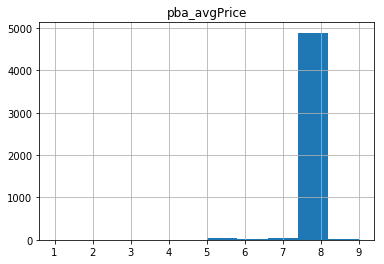

In [59]:
def agg_func(ser):
    nona = ser.dropna()
    if (not nona.empty):
        cnt = nona.count()
        return cnt
    return None

no_half_days = day_group[['pba_avgPrice']].apply(agg_func)
no_half_days.hist()

### 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5a7f2953c8>]],
      dtype=object)

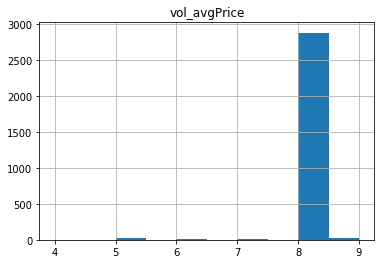

In [60]:
def agg_func(ser):
    nona = ser.dropna()
    if (not nona.empty):
        cnt = nona.count()
        return cnt
    return None

no_half_days_vol = day_group[['vol_avgPrice']].apply(agg_func)
no_half_days_vol.hist()

In [71]:
def hourly_count(ser):
    day_group = ser.groupby(pd.Grouper(freq='B'))
    return day_group.count()

dow_jones_raw_0


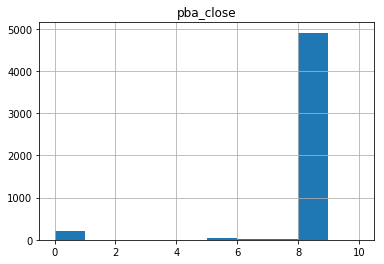

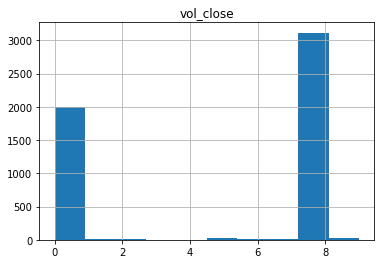

sp_500_raw_1


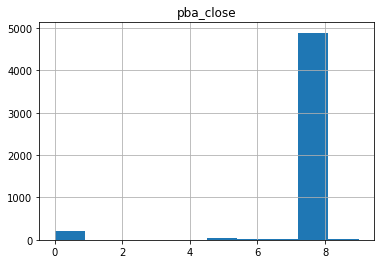

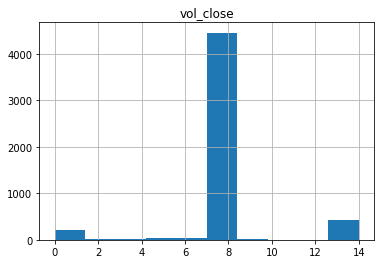

nasdaq_100_raw_2


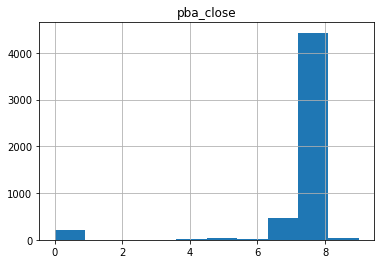

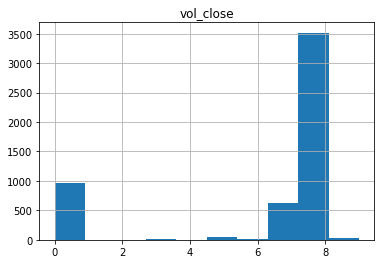

russell_2000_raw_3


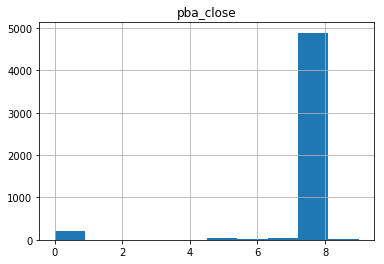

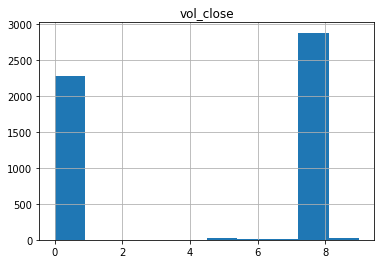

In [82]:
aspect = 'close'
for df_name, df in dfs.items():
    pba_cols = chained_filter(df.columns, [cs['#pba']['ohlc']])
    vol_cols = chained_filter(df.columns, [cs['#vol']['ohlc']])
    pba_vol_df = df.loc[:, pba_cols + vol_cols]
    print(df_name)
    
    plt.title('pba_' +aspect)
    hourly_count(pba_vol_df['pba_avgPrice']).hist()
    plt.show()
    
    plt.title('vol_' +aspect)
    hourly_count(pba_vol_df['vol_avgPrice']).hist()
    plt.show()
#     plt.title(df_name)
#     splt.show()
    
    